#### Data Set Description

link to the data: https://archive.ics.uci.edu/ml/datasets/Heart+Disease
* age: age in years

* sex: sex (1 = male; 0 = female)

* cp: chest pain type
-- Value 1: typical angina
-- Value 2: atypical angina
-- Value 3: non-anginal pain
-- Value 4: asymptomatic
* trestbps: resting blood pressure (in mm Hg on admission to the hospital)

* chol: serum cholestoral in mg/dl

* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

* restecg: resting electrocardiographic results

* thalach: maximum heart rate achieved

* exang: exercise induced angina (1 = yes; 0 = no)

* oldpeak = ST depression induced by exercise relative to rest

* slope: the slope of the peak exercise ST segment
-- Value 1: upsloping
-- Value 2: flat
-- Value 3: downsloping


* ca: number of major vessels (0-3) colored by flourosopy

* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

* target: diagnosis of heart disease (angiographic disease status)
-- Value 0: < 50% diameter narrowing
-- Value 1: > 50% diameter narrowing
(in any major vessel: attributes 59 through 68 are vessels

#### Import packages needed for the analysis

In [4]:
# !pip install -r requirements.txt
import pandas as pd
import logging
import seaborn as sns
import warnings
import statistics 
import numpy as np
import sys
# import shap
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
# from catboost import CatBoostClassifier, Pool

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
logger.handlers = [handler]
logger.info('Python 3.6')
logger.info('Packages: numpy - pandas - matplotlib - shap - seaborn - sklearn - catboost')

Python 3.6
Packages: numpy - pandas - matplotlib - shap - seaborn - sklearn - catboost


#### Read the data

In [7]:
colnames = ['Age','Sex','Chest_pain','Resting_blood_pressure','Cholesterol','Fasting_blood_sugar','ECG_results',\
            'Maximum_heart_rate','Exercise_induced_angina','ST_depression','ST_slope','Major_vessels',\
            'Thalassemia_types','Heart_attack']

dtype = {'Chest_pain':'object','Fasting_blood_sugar':'int64','ECG_results':'object','ST_slope':'int64',
        'Exercise_induced_angina':'int64', 'Age':'int64','Resting_blood_pressure':'int64',
         'Cholesterol':'int64','Maximum_heart_rate':'int64', 'Sex':'int64'}

# data path to change
data_path = '/Users/giorgiomondauto/Desktop/sensyne/'
df = pd.read_csv(os.path.join(data_path,'processed.cleveland_data.txt'), names = colnames, dtype = dtype)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      303 non-null    int64  
 1   Sex                      303 non-null    int64  
 2   Chest_pain               303 non-null    object 
 3   Resting_blood_pressure   303 non-null    int64  
 4   Cholesterol              303 non-null    int64  
 5   Fasting_blood_sugar      303 non-null    int64  
 6   ECG_results              303 non-null    object 
 7   Maximum_heart_rate       303 non-null    int64  
 8   Exercise_induced_angina  303 non-null    int64  
 9   ST_depression            303 non-null    float64
 10  ST_slope                 303 non-null    int64  
 11  Major_vessels            303 non-null    object 
 12  Thalassemia_types        303 non-null    object 
 13  Heart_attack             303 non-null    int64  
dtypes: float64(1), int64(9), o

In [8]:
df['Chest_pain'].iloc[0]

'1.0'

#### EDA

In [28]:
logger.info('The Cleveland Data has shape {}'.format(df.shape))
df.head()

The Cleveland Data has shape (303, 14)


,Age,Sex,Chest_pain,Resting_blood_pressure,Cholesterol,Fasting_blood_sugar,ECG_results,Maximum_heart_rate,Exercise_induced_angina,ST_depression,ST_slope,Major_vessels,Thalassemia_types,Heart_attack
0,63,1,1,145,233,1,2.0,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2.0,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2.0,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0.0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2.0,172,0,1.4,1,0.0,3.0,0


Note: When specifying the dtype in read_csv, I have noticed some unexpected values for Major_vessels and Thalassemia_types features. Let's look into it

In [29]:
crosstab1= df.groupby(['Sex','Major_vessels'])['Heart_attack'].count().reset_index().sort_values(by='Heart_attack',ascending=False)
logger.info('crosstab1')
cm = sns.light_palette("orange", as_cmap=True)
crosstab1.head(10).style.background_gradient(cmap=cm)

crosstab1


,Sex,Major_vessels,Heart_attack
4,1,0.0,111
0,0,0.0,65
5,1,1.0,50
6,1,2.0,25
7,1,3.0,16
1,0,1.0,15
2,0,2.0,13
3,0,3.0,4
8,1,?,4


We can indeed observe four missing values for male patients presenting heart_attack. Since the number is quite small, we can replace it with its most common value. We can also observe that as the number of major blood vessels increases, the number of heart disease cases decreases. 

In [30]:
df['Major_vessels']= df['Major_vessels'].replace('?',statistics.mode(df['Major_vessels']))
# df['Major_vessels'] = df['Major_vessels'].apply(lambda x: int(float(x)))
df.Major_vessels.value_counts()

0.0    180
1.0     65
2.0     38
3.0     20
Name: Major_vessels, dtype: int64

In [31]:
df['Thalassemia_types'] = df['Thalassemia_types'].replace(['3.0','6.0','7.0'],[0,1,2])
crosstab2= df.groupby(['Sex','Thalassemia_types'])['Heart_attack'].count().reset_index().sort_values(by='Heart_attack',ascending=False)
cm = sns.light_palette("orange", as_cmap=True)
logger.info('crosstab2')
crosstab2.head(10).style.background_gradient(cmap=cm)

crosstab2


,Sex,Thalassemia_types,Heart_attack
6,1,2,102
4,1,0,86
0,0,0,80
5,1,1,17
2,0,2,15
1,0,1,1
3,0,?,1
7,1,?,1


We repeat same process as per Major_vessels feature to replace the missing values. Most of the heart attack cases present reversable defect thalassemia type.

In [32]:
df['Thalassemia_types'] = df['Thalassemia_types'].replace('?',statistics.mode(df['Thalassemia_types']))
df.Thalassemia_types.value_counts()

0    168
2    117
1     18
Name: Thalassemia_types, dtype: int64

The target feature "diagnosis of heart disease (angiographic disease status)" refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. We are mainly interested in predicting the presence ( yi > 0) or the absence (yi = 0) of heart disease in the patient.


In [33]:
df['Heart_attack'] = df['Heart_attack'].apply(lambda x: 0 if x==0 else 1)
round(df['Heart_attack'].value_counts()/df.shape[0],2)

0    0.54
1    0.46
Name: Heart_attack, dtype: float64

The number of healthy patients is slightly higher than the number of unhealthy patients.

#### Predictive Model

In [34]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('Heart_attack', axis = 1), df['Heart_attack'], test_size = .2, random_state=10)
logger.info('X_train has shape {}'.format(X_train.shape))
logger.info('X_test has shape {}'.format(X_test.shape))

X_train has shape (242, 13)
X_test has shape (61, 13)


Since we are using CatBoostClassifier, we do not need to preprocess categorical data. 
We only need to indicate them.
- source: https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html
- a Kaggle example of catboostclassifier usage: https://www.kaggle.com/prashant111/catboost-classifier-in-python

In [35]:
categorical_features = np.where((df[colnames].dtypes != np.int) & (df[colnames].dtypes != np.float))[0]
params = {'iterations':5000,
        'learning_rate':0.01,
        'cat_features':categorical_features,
        'depth':3,
        'eval_metric':'AUC',
        'verbose':200,
        'od_type':"Iter",
        'od_wait':500,
        'random_seed': 1
          }
clf = CatBoostClassifier(**params)
clf.fit(X_train, y_train,   
          eval_set=(X_test, y_test), 
          use_best_model=True,
          plot=True  
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8602151	best: 0.8602151 (0)	total: 11.7ms	remaining: 58.5s
200:	test: 0.9279570	best: 0.9376344 (29)	total: 286ms	remaining: 6.82s
400:	test: 0.9236559	best: 0.9376344 (29)	total: 512ms	remaining: 5.87s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.9376344086
bestIteration = 29

Shrink model to first 30 iterations.


calculate confusion matrix - sensitivity - specificity - accuracy

In [36]:
predicted = clf.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
total=sum(matrix)
sensitivity = matrix[0,0]/(matrix[0,0]+matrix[1,0])
logger.info('Sensitivity : {}'.format(round(sensitivity,3)))
specificity = matrix[1,1]/(matrix[1,1]+matrix[0,1])
logger.info('Specificity : {}'.format(round(specificity,3)))
accuracy = (matrix[0,0] + matrix[1,1])/X_test.shape[0]
logger.info('Accuracy : {}'.format(round(accuracy,3)))

Sensitivity : 0.867
Specificity : 0.839
Accuracy : 0.852


AUC is 0.9376344086021505


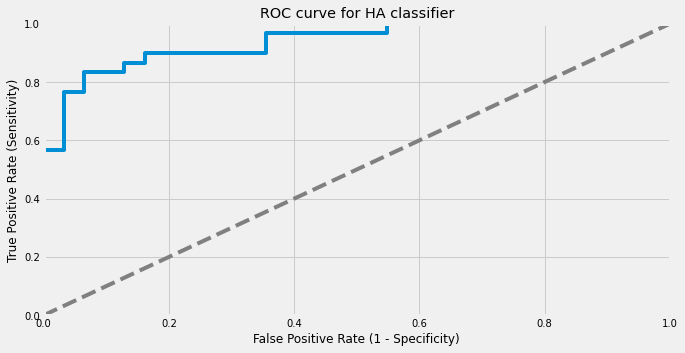

In [38]:
y_pred_quant = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)
logger.info('AUC is {}'.format(auc(fpr, tpr)))
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".5")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 10
plt.title('ROC curve for HA classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

#### Features Importance
I will use SHAP summary plots to provide more insights. 
- source: https://shap.readthedocs.io/_/downloads/en/stable/pdf/
- a Kaggle example of shap usage: https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values 

locator: <matplotlib.ticker.FixedLocator object at 0x11de329e8>
Using auto colorbar locator <matplotlib.ticker.FixedLocator object at 0x11de329e8> on colorbar
Setting pcolormesh
locator: <matplotlib.ticker.FixedLocator object at 0x11de329e8>
Using auto colorbar locator <matplotlib.ticker.FixedLocator object at 0x11de329e8> on colorbar


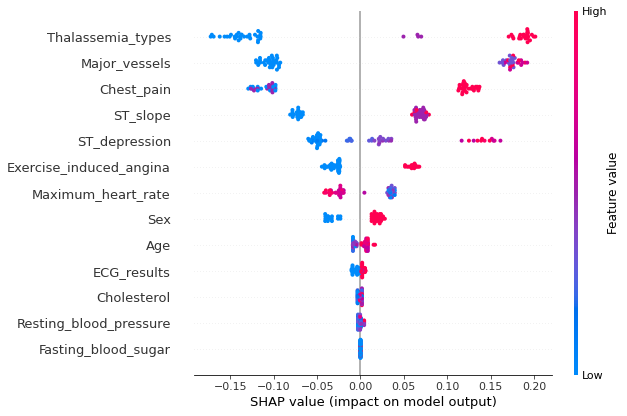

In [15]:
shap_values = clf.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features) ,
                                               type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X_test)

From the above plot, Features like ECG_results, Resting_blood_pressure, Cholesterol, and Fasting_blood_sugar do not seem to affect the prediction.

Some comments:

--- 
* As we already observed in crosstab1, when the number of major vessels increases the higher are the changes of heart attack cases.


* As we observed in crosstab2, Most of the heart attack cases present reversable defect thalassemia type (the higher is the value of this feature and the higher are the chances for the patient to undergo a heart attack.)


* Age and Sex also seem to affect the outcome. Below (crosstab3 and plot1) shows the relationship between those features with the target


* Strong relationship there is also between high values of St_depression, ST_slope, Exercise_induced_angina and Heart_attack


* What I find surprising are the results for Chest pain. I was expecting that patients with heart attack would present higher cases of typ angina (the discomfort that is noted when the heart does not get enough blood or oxygen) and very few cases of asympt chest pain. The results do not seem to say so. Below Crosstab4 also confirms the analysis. 

##### Age - Sex - Heart_Attack

In [39]:
logger.info('crosstab3')
crosstab3= df.groupby(['Sex','Age'])['Heart_attack'].count().reset_index().sort_values(by='Heart_attack',ascending=False)
cm = sns.light_palette("orange", as_cmap=True)
crosstab3.head(10).style.background_gradient(cmap=cm)

crosstab3


,Sex,Age,Heart_attack
59,1,58,13
58,1,57,13
60,1,59,13
53,1,52,12
55,1,54,11
45,1,44,9
57,1,56,8
52,1,51,8
65,1,64,7
24,0,62,7


plot1


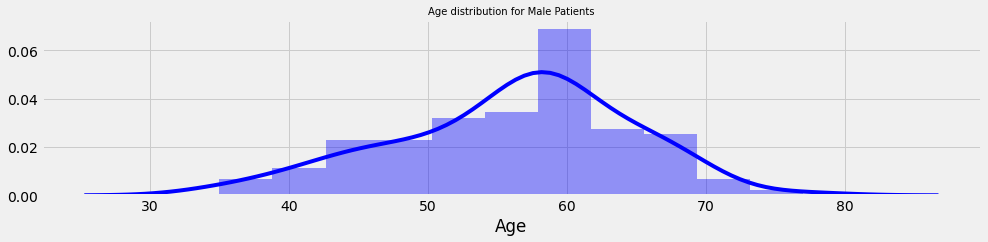

In [40]:
logger.info('plot1')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 3)
sns.distplot(df[(df['Heart_attack'] == 1) & (df['Sex'] == 1)]['Age'], color = 'blue')
plt.title('Age distribution for Male Patients', fontsize = 10)
plt.show()

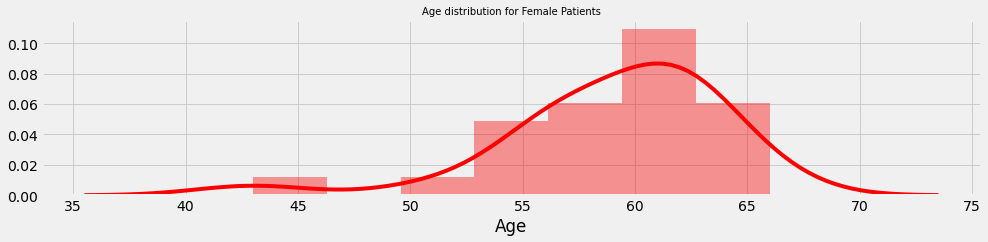

In [41]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 3)
sns.distplot(df[(df['Heart_attack'] == 1) & (df['Sex'] == 0)]['Age'], color = 'red')
plt.title('Age distribution for Female Patients', fontsize = 10)
plt.show()

plot2


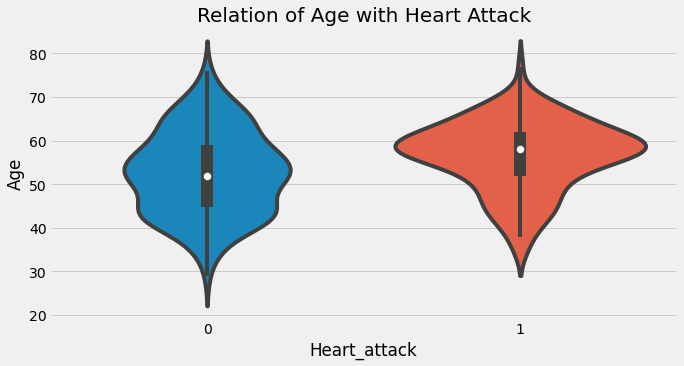

In [42]:
logger.info('plot2')
plt.rcParams['figure.figsize'] = (10, 5)
sns.violinplot(df['Heart_attack'], df['Age'])
plt.title('Relation of Age with Heart Attack', fontsize = 20, fontweight = 30)
plt.show()

In the top 10 count of heart attack cases, mainly male patients have undergone a heart attack (Plot1). From the above Age distributions, we can also notice that most of the male patients with heart attack are aged between 40-70 while most of the female patients are aged between 50-65 (smaller range). The Violin Plot (plot2) confirms the behaviour of the Age distribution. 

##### Chest_pain - Heart_attack 

logger.info('crosstab4')
crosstab4= df.groupby(['Sex','Chest_pain'])['Heart_attack'].count().reset_index().sort_values(by='Heart_attack',ascending=False)
crosstab4.head(10).style.background_gradient(cmap=cm)